In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

sys.path.append('..')
import deepomics

from deepomics import neuralnetwork as nn
from deepomics import utils, fit

In [2]:
def load_dataset(data_path):
    import gzip
    def load_mnist_images(filename):
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        data = data.reshape(-1, 28*28)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images(os.path.join(data_path,'train-images-idx3-ubyte.gz'))
    y_train = load_mnist_labels(os.path.join(data_path,'train-labels-idx1-ubyte.gz'))
    X_test = load_mnist_images(os.path.join(data_path,'t10k-images-idx3-ubyte.gz'))
    y_test = load_mnist_labels(os.path.join(data_path,'t10k-labels-idx1-ubyte.gz'))

    return X_train, y_train, X_test, y_test

# load the data
data_path = '../data/MNIST'
X_train, y_train, X_test, y_test = load_dataset(data_path)


width = 28
height = 28

# place data as a dictionary
train = {'inputs': X_train, 'targets': X_train}
test = {'inputs': X_test, 'targets': X_test}


input_shape = list(X_train.shape)
input_shape[0] = None
output_shape = input_shape

In [3]:
def model(input_shape, output_shape):

    # create model
    layer1 = {'layer': 'input', #41
            'input_shape': input_shape
            }
    layer2 = {'layer': 'dense',
            'num_units': 256,
            'activation': 'leaky_relu',
            'dropout': 0.1,
            }
    layer3 = {'layer': 'variational_normal',
            'num_units': 30,
            'name': 'Z',
            }
    layer4 = {'layer': 'dense',
            'num_units': 256,
            'activation': 'leaky_relu',
            'dropout': 0.1,
            }
    layer5 = {'layer': 'variational_normal',
            'num_units': output_shape[1],
            'activation': 'sigmoid',
            'name': 'X'
             }
    
    #from tfomics import build_network
    model_layers = [layer1, layer2, layer3, layer4, layer5]

    # optimization parameters
    optimization = {"objective": "elbo_gaussian_binary",
                  "optimizer": "adam",
                  "learning_rate": 0.0003,
                  "beta1": 0.9, 
                  "l2": 1e-6,
                  }
    return model_layers, optimization

tf.reset_default_graph()

# get model info
model_layers, optimization = model(input_shape, output_shape)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization, supervised=False)
nnmodel.inspect_layers()

# compile neural trainer
model_save_path = os.path.join('../results/MNIST', 'deepomics_vae')
nntrainer = nn.NeuralTrainer(nnmodel, save=None, file_path=model_save_path)

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: inputs
(?, 784)
layer2: dense_0
(?, 256)
layer3: dense_0_bias
(?, 256)
layer4: dense_0_active
(?, 256)
layer5: dense_0_dropout
(?, 256)
layer6: Z_mu
(?, 30)
layer7: Z_logvar
(?, 30)
layer8: Z_sample
(?, 30)
layer9: dense_1
(?, 256)
layer10: dense_1_bias
(?, 256)
layer11: dense_1_active
(?, 256)
layer12: dense_1_dropout
(?, 256)
layer13: X_mu
(?, 784)
layer14: X_logvar
(?, 784)
layer15: X_sample
(?, 784)
layer16: X
(?, 784)
----------------------------------------------------------------------------


# Train model

### Start session

In [4]:
# initialize session
sess = utils.initialize_session()

### fit data

In [5]:
data = {'train': train}
fit.train_minibatch(sess, nntrainer, data, batch_size=128,
                    num_epochs=50, patience=None, verbose=2, shuffle=True)

Epoch 1 out of 50 
[==============================] 100.0% -- time=11s -- loss=184.41320 
Epoch 2 out of 50 
[==============================] 100.0% -- time=11s -- loss=135.21188 
Epoch 3 out of 50 
[==============================] 100.0% -- time=11s -- loss=126.64754 
Epoch 4 out of 50 
[==============================] 100.0% -- time=11s -- loss=122.49563 
Epoch 5 out of 50 
[==============================] 100.0% -- time=11s -- loss=120.08259 
Epoch 6 out of 50 
[==============================] 100.0% -- time=11s -- loss=118.31327 
Epoch 7 out of 50 
[==============================] 100.0% -- time=11s -- loss=117.20515 
Epoch 8 out of 50 
[==============================] 100.0% -- time=11s -- loss=116.26010 
Epoch 9 out of 50 
[==============================] 100.0% -- time=11s -- loss=115.52629 
Epoch 10 out of 50 
[==============================] 100.0% -- time=11s -- loss=114.98991 
Epoch 11 out of 50 
[==============================] 100.0% -- time=11s -- loss=114.50740 
Epoch 12

KeyboardInterrupt: 

# Evaluate model

### Let's sample the latent space about points that real data map to

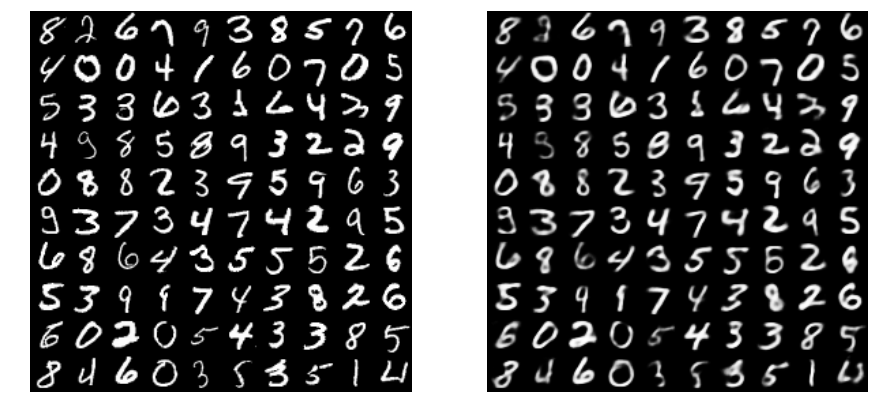

In [6]:
# randomly select a set number of training samples
num_grid = 10
shuffle = np.random.permutation(X_test.shape[0])
X_data = X_test[shuffle[:num_grid*num_grid]]

# get the generated images about the latent space where the training samples mapped to
samples = nntrainer.get_activations(sess, {'inputs': X_data}, layer='X')

# plot training samples and generated trainingsamples
fig = plt.figure()
ax = plt.subplot(1,2,1);
ax.imshow((X_data.reshape(num_grid, num_grid, 28, 28)
                   .transpose(0, 2, 1, 3)
                   .reshape(num_grid*28, num_grid*28)), cmap='gray')
ax.axis('off')
ax = plt.subplot(1,2,2);
ax.imshow((samples.reshape(num_grid, num_grid, 28, 28)
                   .transpose(0, 2, 1, 3)
                   .reshape(num_grid*28, num_grid*28)), cmap='gray')
ax.axis('off')
fig.set_size_inches(15,15)

### visualize the latent space learned by the VAE

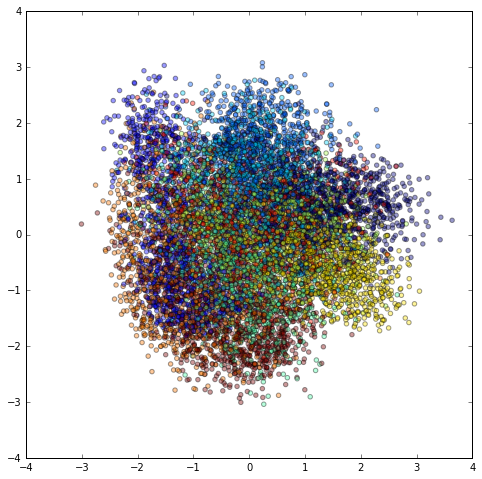

In [7]:
# extract latent space for training data
z_coord = nntrainer.get_activations(sess, {'inputs': X_test}, layer='Z_mu')

# perform PCA on latent space if more than 2 latent variables
if z_coord.shape[1] > 2:
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    z_reduce = pca.fit_transform(z_coord)
else:
    z_reduce = z_coord

# plot latent space coordinates of each data point
plt.figure(figsize=(8,8))
plt.scatter(z_reduce[:,0], z_reduce[:,1], c=y_test[:z_reduce.shape[0]].astype(int), cmap='jet',alpha=.4);